In [2]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.layers import Input, Flatten, Dense, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# ===============================================================
# 1. DATA PREPARATION
# ===============================================================
img_size = 224
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    'Dataset',
    target_size=(img_size, img_size),
    batch_size=32,
    subset='training',
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    'Dataset',
    target_size=(img_size, img_size),
    batch_size=32,
    subset='validation',
    class_mode='categorical',
    shuffle=False
)

# ===============================================================
# 2. DEFINE BASE MODELS
# ===============================================================
input_layer = Input(shape=(img_size, img_size, 3))

# --- VGG16 ---
vgg_model = VGG16(include_top=False, weights='imagenet', input_tensor=input_layer)
for layer in vgg_model.layers:
    layer.trainable = False

# --- ResNet50 ---
resnet_model = ResNet50(include_top=False, weights='imagenet', input_tensor=input_layer)
for layer in resnet_model.layers:
    layer.trainable = False

# --- InceptionV3 ---
inception_model = InceptionV3(include_top=False, weights='imagenet', input_tensor=input_layer)
for layer in inception_model.layers:
    layer.trainable = False

# ===============================================================
# 3. FEATURE EXTRACTION
# ===============================================================
vgg_features = Flatten()(vgg_model.output)
resnet_features = Flatten()(resnet_model.output)
inception_features = Flatten()(inception_model.output)

# Concatenate features from all 3 networks
concat = concatenate([vgg_features, resnet_features, inception_features])

# ===============================================================
# 4. META MODEL (CLASSIFICATION LAYERS)
# ===============================================================
x = Dense(512, activation='relu')(concat)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)

# ===============================================================
# 5. FINAL STACKED MODEL
# ===============================================================
stacked_model = Model(inputs=input_layer, outputs=output)

stacked_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

# ===============================================================
# 6. TRAINING
# ===============================================================
hist = stacked_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=8
)

# ===============================================================
# 7. SAVE MODEL
# ===============================================================
stacked_model.save('ashwagandha_stacked_model.h5')

print("Model training complete and saved as 'ashwagandha_stacked_model.h5'")

Found 480 images belonging to 2 classes.


Found 118 images belonging to 2 classes.


c:\Users\SAKSHI\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 88s 5s/step - accuracy: 0.5500 - loss: 24.7250 - val_accuracy: 0.8220 - val_loss: 2.1961
Epoch 2/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.6979 - loss: 11.7267 - val_accuracy: 0.8644 - val_loss: 1.0084
Epoch 3/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.7750 - loss: 7.0901 - val_accuracy: 0.8475 - val_loss: 1.6512
Epoch 4/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.8479 - loss: 3.4342 - val_accuracy: 0.8983 - val_loss: 0.8843
Epoch 5/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.9000 - loss: 1.7115 - val_accuracy: 0.8729 - val_loss: 1.3301
Epoch 6/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.9312 - loss: 1.0820 - val_accuracy: 0.9322 - val_loss: 0.7409
Epoch 7/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.9479 - loss: 0.5006 - val_accuracy: 0.9237 - val_loss: 0.9611
Epoch 8/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.9521 - loss: 0.5436 - val_accuracy: 0.9322 - val_loss: 1.469

Model training complete and saved as 'ashwagandha_stacked_model.h5'


4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step


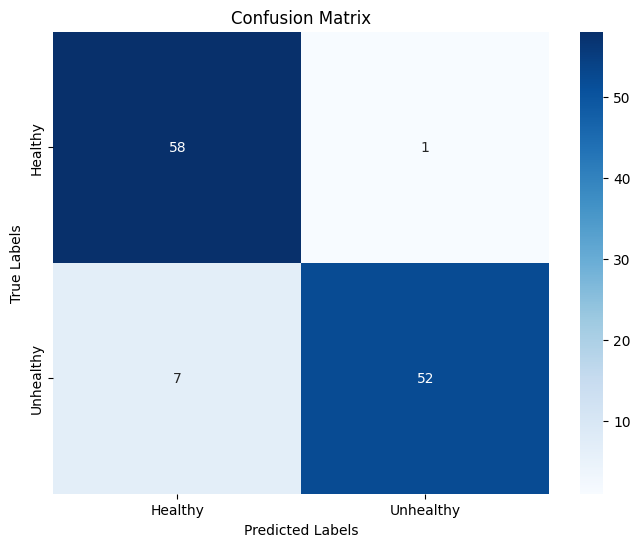


Classification Report:
              precision    recall  f1-score   support

     Healthy       0.89      0.98      0.94        59
   Unhealthy       0.98      0.88      0.93        59

    accuracy                           0.93       118
   macro avg       0.94      0.93      0.93       118
weighted avg       0.94      0.93      0.93       118

93.22033898305084 %


In [4]:
# =========================================================
# CONFUSION MATRIX & ROC-AUC FOR STACKED MODEL
# =========================================================

import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# =========================================================
# 1. LOAD MODEL & VALIDATION DATA
# =========================================================
stacked_model = tf.keras.models.load_model('ashwagandha_stacked_model.h5')

# make sure your val_gen is defined in this notebook before this cell
val_gen.reset()

# =========================================================
# 2. PREDICTIONS
# =========================================================
y_pred_probs = stacked_model.predict(val_gen, verbose=1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# =========================================================
# 3. CONFUSION MATRIX
# =========================================================
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Detailed precision, recall, and F1-score
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

accuracy = accuracy_score(y_true, y_pred_classes)
print(accuracy*100,"%")

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)
import numpy as np

# =========================================================
# 1️⃣  TRUE & PREDICTED LABELS
# =========================================================
y_true = val_gen.classes
y_pred_probs = stacked_model.predict(val_gen, verbose=1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# =========================================================
# 2️⃣  BASIC METRICS
# =========================================================
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred_classes, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred_classes, average='macro', zero_division=0)

# =========================================================
# 3️⃣  CONFUSION MATRIX (for Specificity, FPR, etc.)
# =========================================================
cm = confusion_matrix(y_true, y_pred_classes)

# For multi-class: we’ll compute per-class stats and take averages
num_classes = cm.shape[0]
specificity_list, fpr_list, tpr_list, lr_plus_list = [], [], [], []

for i in range(num_classes):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FP + FN)

    # Avoid divide-by-zero
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    tpr = TP / (TP + FN) if (TP + FN) != 0 else 0  # Recall
    fpr = FP / (FP + TN) if (FP + TN) != 0 else 0
    lr_plus = tpr / (1 - specificity) if (1 - specificity) != 0 else 0

    specificity_list.append(specificity)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    lr_plus_list.append(lr_plus)

# Take macro averages for overall metrics
specificity = np.mean(specificity_list)
fpr = np.mean(fpr_list)
tpr = np.mean(tpr_list)
lr_plus = np.mean(lr_plus_list)

# =========================================================
# 4️⃣  MISCLASSIFICATION RATE
# =========================================================
misclassification_rate = 1 - accuracy

# =========================================================
# 5️⃣  PRINT RESULTS
# =========================================================
print("=========== MODEL PERFORMANCE METRICS ===========")
print("Accuracy: ", accuracy * 100, "%")
print("Precision (Macro): ", precision * 100, "%")
print("Recall / Sensitivity: ", recall * 100, "%")
print("F1 Score (Macro): ", f1 * 100, "%")
print("Specificity (TNR): ", specificity * 100, "%")
print("True Positive Rate: ", tpr * 100, "%")
print("False Positive Rate: ", fpr * 100, "%")
print("Misclassification: ", misclassification_rate * 100, "%")
print("Positive Likelihood: ", lr_plus * 100, "%")



4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
=========== MODEL PERFORMANCE METRICS ===========
Accuracy:  93.22033898305084 %
Precision (Macro):     0.9367
Recall / Sensitivity:  0.9322
F1 Score (Macro):      0.9320
Specificity (TNR):     0.9322
True Positive Rate:    0.9322
False Positive Rate:   0.0678
Misclassification:     0.0678
Positive Likelihood:   30.1429


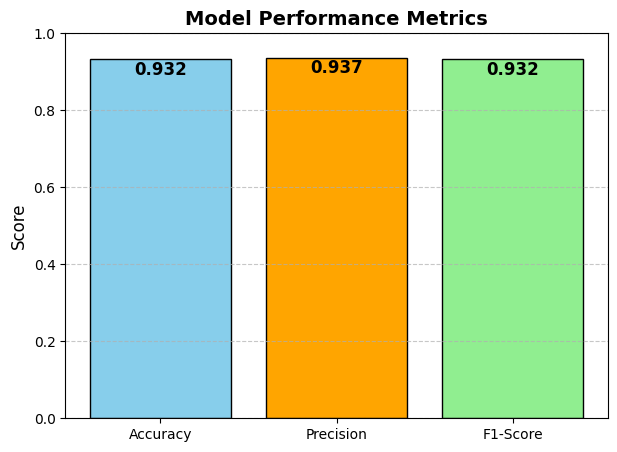

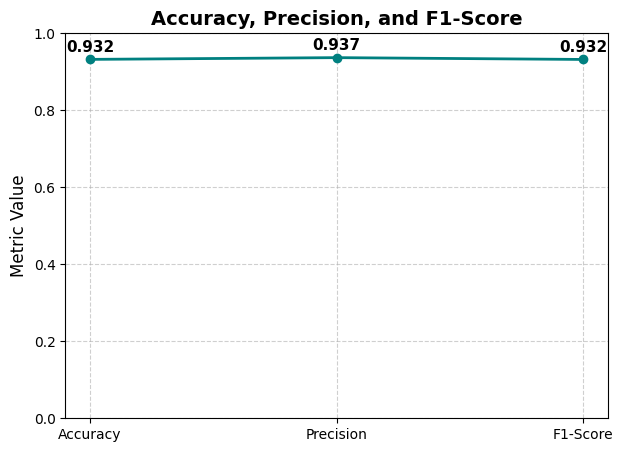

In [9]:
import matplotlib.pyplot as plt

# ===============================================
# Suppose you already calculated:
# accuracy, precision, recall, f1
# ===============================================

# Create metric names and their values
metrics = ['Accuracy', 'Precision', 'F1-Score']
values = [accuracy, precision, f1]

# ===============================================
# BAR CHART
# ===============================================
plt.figure(figsize=(7,5))
bars = plt.bar(metrics, values, color=['skyblue', 'orange', 'lightgreen'], edgecolor='black')

# Add text labels on bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.05,
             f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title("Model Performance Metrics", fontsize=14, fontweight='bold')
plt.ylabel("Score", fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# ===============================================
# LINE PLOT (optional alternative)
# ===============================================
plt.figure(figsize=(7,5))
plt.plot(metrics, values, marker='o', color='teal', linewidth=2)
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f"{val:.3f}", ha='center', fontsize=11, fontweight='bold')

plt.title("Accuracy, Precision, and F1-Score", fontsize=14, fontweight='bold')
plt.ylabel("Metric Value", fontsize=12)
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
